In [1]:
%matplotlib inline


# Faces recognition example using eigenfaces and SVMs


The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

.. _LFW: http://vis-www.cs.umass.edu/lfw/

Expected results for the top 5 most represented people in the dataset:

================== ============ ======= ========== =======
                   precision    recall  f1-score   support
================== ============ ======= ========== =======
     Ariel Sharon       0.67      0.92      0.77        13
     Colin Powell       0.75      0.78      0.76        60
  Donald Rumsfeld       0.78      0.67      0.72        27
    George W Bush       0.86      0.86      0.86       146
Gerhard Schroeder       0.76      0.76      0.76        25
      Hugo Chavez       0.67      0.67      0.67        15
       Tony Blair       0.81      0.69      0.75        36

      avg / total       0.80      0.80      0.80       322
================== ============ ======= ========== =======



In [1]:
#from __future__ import print_function
from time import time
import logging
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import requests
from bs4 import BeautifulSoup
import io

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

#print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

Download the data, if not already on disk and load it as numpy arrays


In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
type(lfw_people)


2017-07-20 23:28:11,847 Loading LFW people faces from /home/bhaskar/scikit_learn_data/lfw_home


sklearn.datasets.base.Bunch

In [3]:
print(lfw_people.images.shape)
print(lfw_people.data.shape)
lfw_people.target_names

(1288, 50, 37)
(1288, 1850)


array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair'], 
      dtype='<U17')

In [4]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


Split into a training set and a test set using a stratified k fold


In [5]:
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
dataset): unsupervised feature extraction / dimensionality reduction


In [6]:
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 966 faces
done in 0.175s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.017s


Train a SVM classification model


In [7]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 21.455s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


Quantitative evaluation of the model quality on the test set


In [8]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.047s
                   precision    recall  f1-score   support

     Ariel Sharon       0.55      0.46      0.50        13
     Colin Powell       0.75      0.82      0.78        60
  Donald Rumsfeld       0.71      0.74      0.73        27
    George W Bush       0.88      0.92      0.90       146
Gerhard Schroeder       0.77      0.80      0.78        25
      Hugo Chavez       0.88      0.93      0.90        15
       Tony Blair       0.92      0.61      0.73        36

      avg / total       0.83      0.82      0.82       322

[[  6   4   2   1   0   0   0]
 [  2  49   1   6   1   0   1]
 [  2   2  20   2   0   1   0]
 [  1   6   3 134   1   0   1]
 [  0   2   0   2  20   1   0]
 [  0   0   0   1   0  14   0]
 [  0   2   2   6   4   0  22]]


Qualitative evaluation of the predictions using matplotlib


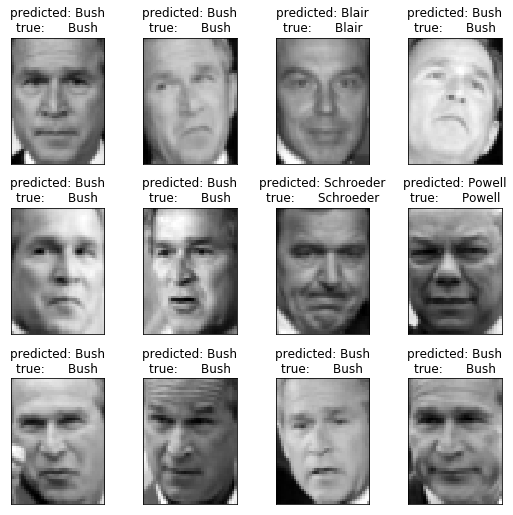

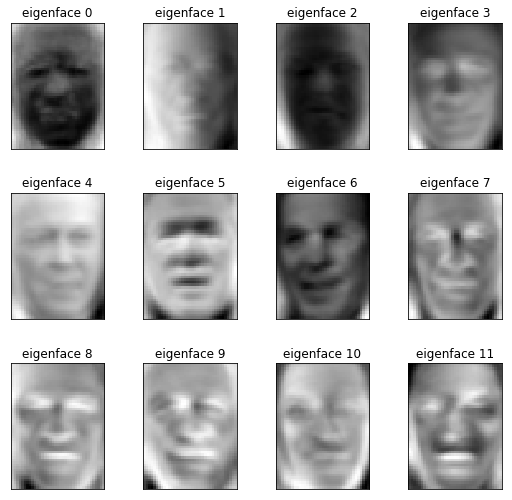

In [9]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

### comparision with pca using different param grid and deault pca parameters(not using randomised and whiten)
### and default svc parameters(not using balanced weights)

In [10]:
#plt.plot()
#plt.imshow(lfw_people.images[1,...])
print(type(lfw_people.images))
print(lfw_people.images.shape)
img1 = lfw_people.images[0,...]
print(type(img1),img1.shape)
dat1 = lfw_people.data[0,...].reshape((h,w))
print(type(dat1),dat1.shape)
plt.subplot(1,2,1)
plt.imshow(img1, cmap=plt.cm.gray)
plt.title("plot from image")
plt.subplot(1,2,2)
plt.imshow(dat1,cmap=plt.cm.gray)
plt.title("plot from data")
#plt.show()
#conclusion , Image and data are same thing , but pca acceps maximum 2 dimensions to compute components, hence if we use Image as X, we need to ravel() it anyway

<class 'numpy.ndarray'>
(1288, 50, 37)
<class 'numpy.ndarray'> (50, 37)
<class 'numpy.ndarray'> (50, 37)


In [11]:
print(lfw_people.target_names)
sum(lfw_people.target==3)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']


530

In [12]:
x = lfw_people.data
y = lfw_people.target

xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.25,random_state=42)
#t0= time()
pca = PCA(n_components=150,whiten=True,svd_solver="randomized").fit(xtrain)
#How to replicate the same classification report for each run of this block
#whiten = True scales each component to unit variance, for models such as SVM and KMeans which are sensitive to scale in the data, it is useful
# for this data, the loadings of all classes except GWBush is 0 without whiten=True
#svd_solver="randomized" is efficient while dropping number_of_components as we need not calculate full components
#0.24255991 ,0.27382612   and 0.22934437, 0.22793102 without and with
#print("time taken %1.8f "%(time()-t0))
xtrain_pca = pca.transform(xtrain)
xtest_pca = pca.transform(xtest)
parameters = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}

clf = GridSearchCV(SVC(kernel="rbf",class_weight="balanced"),param_grid=parameters).fit(xtrain_pca,ytrain)
# weights = "balanced" gives higher priority to less frequent class, weights inversely proprtional to  frequencies
# in this case not much difference in classification report .weights="balanced" is always a good start

yhat = clf.predict(xtest_pca)

print(classification_report(y_test, yhat, target_names=target_names))
print(confusion_matrix(y_test, yhat, labels=range(n_classes)))


                   precision    recall  f1-score   support

     Ariel Sharon       0.67      0.62      0.64        13
     Colin Powell       0.75      0.78      0.76        60
  Donald Rumsfeld       0.78      0.78      0.78        27
    George W Bush       0.88      0.90      0.89       146
Gerhard Schroeder       0.81      0.84      0.82        25
      Hugo Chavez       0.82      0.93      0.87        15
       Tony Blair       0.89      0.67      0.76        36

      avg / total       0.83      0.83      0.83       322

[[  8   3   0   2   0   0   0]
 [  2  47   1   8   1   0   1]
 [  1   2  21   2   0   1   0]
 [  1   6   3 132   2   0   2]
 [  0   2   0   1  21   1   0]
 [  0   0   0   1   0  14   0]
 [  0   3   2   4   2   1  24]]


In [13]:
ash = requests.get('https://www.google.co.in/search?q=face+of+aishwarya+rai&client=ubuntu&hs=8Gl&channel=fs&source=lnms&tbm=isch&sa=X&ved=0ahUKEwiewMTk3pTVAhUEVrwKHcrqD90Q_AUICigB&biw=1855&bih=953')
close_up = requests.get('https://www.google.co.in/search?q=aishwarya+closeup&source=lnms&tbm=isch&sa=X&ved=0ahUKEwjN1p3Kl5fVAhVFG5QKHdIhDkIQ_AUICigB&biw=1855&bih=953')
facial = requests.get('https://www.google.co.in/search?q=aishwarya+rai+facial&client=ubuntu&hs=mYm&channel=fs&source=lnms&tbm=isch&sa=X&ved=0ahUKEwjX4-aOmZfVAhVIfLwKHauVCLUQ_AUICygC&biw=1855&bih=953')
soup = BeautifulSoup(ash.text,'html.parser')
soup2 = BeautifulSoup(close_up.text,'html.parser')
soup3 = BeautifulSoup(facial.text,'html.parser')

In [14]:
from IPython.core.display import HTML
HTML(close_up.text)

In [15]:
links =  [src['src'] for src in soup.find_all('img')]
links+= [src['src'] for src in soup2.find_all('img')]
links+= [src['src'] for src in soup3.find_all('img')]
print(len(links))

60


In [16]:
def get_image_matrix(link):
    #default indentation in this notebook is 2, change it to 4
    #img = sp.misc.imread(urllib.request.urlopen("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTSRNVw8Wic-KXs5ITbCjeoMnSAJAd5MN4nMyQrX3jhFWvA8LY8Npdh_x2I8A"))
    #imread returns file object directly, so need not use io.Bytesio here
       image_bytes = io.BytesIO(requests.get(link).content)
       img = sp.misc.imread(image_bytes,mode = 'F')
       img = sp.misc.imresize(img, (50, 37),mode='F')
       return img.ravel()

In [17]:
#d = np.vstack([lfw_people.data,katrina.ravel().reshape(1,-1)])
new_images = [get_image_matrix(link) for link in links]
new_images = np.array(new_images).reshape(60,1850)

In [18]:
lfw_people.data.shape

(1288, 1850)

In [19]:
new_data = np.vstack([lfw_people.data,np.array(new_images).reshape(60,1850)])
new_data.shape

(1348, 1850)

In [20]:
newy = np.hstack([y,np.repeat(7,repeats=60)])
newy.shape

(1348,)

In [21]:
new_targets = np.hstack([target_names,"Ash"])

In [22]:
new_targets

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair', 'Ash'], 
      dtype='<U17')

In [23]:
xtrain,xtest,ytrain,ytest = train_test_split(new_data,newy,test_size=0.25,random_state=42)
pca = PCA(n_components=150,whiten=True,svd_solver = "randomized").fit(xtrain)
xtrain_pca = pca.transform(xtrain)
xtest_pca = pca.transform(xtest)
clf = GridSearchCV(SVC(kernel="rbf",class_weight="balanced"),param_grid=parameters).fit(xtrain_pca,ytrain)
print(clf.best_estimator_)
yhat = clf.predict(xtest_pca)
print(classification_report(ytest, yhat, target_names=new_targets))
print(confusion_matrix(ytest, yhat, labels=range(8)))

SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.53      0.69        17
     Colin Powell       0.85      0.87      0.86        52
  Donald Rumsfeld       0.81      0.73      0.77        30
    George W Bush       0.79      0.97      0.87       139
Gerhard Schroeder       0.94      0.64      0.76        25
      Hugo Chavez       1.00      0.85      0.92        20
       Tony Blair       0.96      0.70      0.81        37
              Ash       0.94      0.88      0.91        17

      avg / total       0.86      0.85      0.84       337

[[  9   2   3   3   0   0   0   0]
 [  0  45   0   6   0   0   1   0]
 [  0   1  22   7   0   0   0   0]
 [  0   2   1 135   0   0   0   1]
 [  0   1   0   8  16   0   0   0]



 *Even though precision and recall is good for ash, we should note that these images differ from rest of the bunch in their collection process and also note that in faces data face occupies the entire image, as seen with the images below, even bush if its a complete picture as opposed to only face, its close to Ash than it is for bush from training.*


#katrina =  sp.misc.imread("katrina.jpeg",mode = 'F')
#katrina = sp.misc.imresize(katrina, (50, 37),mode='F')
#sneha = sp.misc.imread("snehaullal.jpeg",mode = 'F')
#sneha = sp.misc.imresize(sneha,(50, 37),mode = 'F')
#shah = sp.misc.imread("shahrukh.jpeg",mode = 'F')
#shah = sp.misc.imresize(shah,(50, 37),mode = 'F')
#kamal = sp.misc.imread("kamal.jpeg",mode = 'F')
#kamal = sp.misc.imresize(kamal,(50, 37),mode = 'F')
#dashavataram = sp.misc.imread("dashavataram.jpeg",mode = 'F')
#dashavataram = sp.misc.imresize(dashavataram,(50, 37),mode = 'F')
#ponting = sp.misc.imread("ponting.jpeg",mode = 'F')
#ponting = sp.misc.imresize(ponting,(50, 37),mode = 'F')
#bush = sp.misc.imread("bush.jpeg",mode = 'F')
#bush = sp.misc.imresize(bush,(50, 37),mode = 'F')
#bush2 =  sp.misc.imread("bush2.jpeg",mode = 'F')
#bush2 = sp.misc.imresize(bush2,(50, 37),mode = 'F')
#bush3 =  sp.misc.imread("bush3.jpeg",mode = 'F')
#bush3 = sp.misc.imresize(bush3,(50, 37),mode = 'F')
#test_data = np.vstack([katrina.ravel(),sneha.ravel(),shah.ravel(),kamal.ravel(),dashavataram.ravel(),ponting.ravel(),bush.ravel(),bush2.ravel(),bush3.ravel()])

test_data_pca = pca.transform(test_data)
yhat = clf.predict(test_data_pca)
yhat # interesting that any image which is not a closeup of human face is ash for this classifier,see how bush2 is bush and bush3 is ash

target_names